C:\Users\disha\AppData\Local\Temp\ipykernel_9788\3803371281.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Dates'] = pd.to_datetime(df['Dates'])


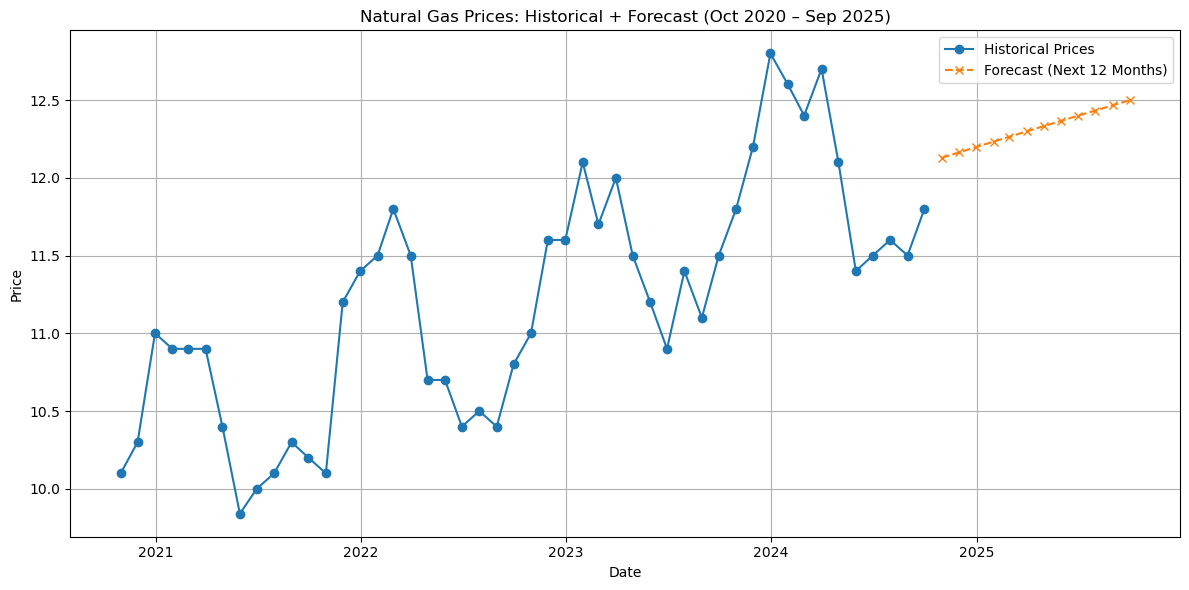

Estimated natural gas price on 2025-09-02: 12.47


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures


df = pd.read_csv("Nat_Gas.csv")
df['Dates'] = pd.to_datetime(df['Dates'])
df.set_index('Dates', inplace=True)


df['Date_Ordinal'] = df.index.map(pd.Timestamp.toordinal)
X = df['Date_Ordinal'].values.reshape(-1, 1)
y = df['Prices'].values


degree = 4
poly = PolynomialFeatures(degree)
X_poly = poly.fit_transform(X)
model = LinearRegression()
model.fit(X_poly, y)


future_dates = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')
future_ordinals = future_dates.map(pd.Timestamp.toordinal).values.reshape(-1, 1)
future_poly = poly.transform(future_ordinals)
future_preds = model.predict(future_poly)


plt.figure(figsize=(12, 6))
plt.plot(df.index, y, label='Historical Prices', marker='o')
plt.plot(future_dates, future_preds, label='Forecast (Next 12 Months)', marker='x', linestyle='--')
plt.title('Natural Gas Prices: Historical + Forecast (Oct 2020 – Sep 2025)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


def estimate_gas_price(input_date_str):
    """
    Estimate the price of natural gas for a given date string in 'YYYY-MM-DD' format.
    """
    try:
        input_date = pd.to_datetime(input_date_str)
        input_ordinal = np.array([[input_date.toordinal()]])
        input_poly = poly.transform(input_ordinal)
        estimated_price = model.predict(input_poly)[0]
        return round(estimated_price, 2)
    except Exception as e:
        return f"Error: {e}"

# Example usage
date_input = "2025-09-02"
estimated = estimate_gas_price(date_input)
print(f"Estimated natural gas price on {date_input}: {estimated}")


In [2]:
from collections import defaultdict
import pandas as pd
import numpy as np

def price_storage_contract(
    injection_dates,        
    withdrawal_dates,       
    injection_rate,         
    withdrawal_rate,        
    max_storage_volume,    
    storage_cost_per_unit   
):
    storage_volume = 0.0
    cash_flows = []
    storage_by_month = defaultdict(float)

    all_dates = sorted(set(injection_dates + withdrawal_dates))
    
    for date_str in all_dates:
        date = pd.to_datetime(date_str)
        price = estimate_gas_price(date_str)

        # Injection
        if date_str in injection_dates:
            inject_amount = min(injection_rate, max_storage_volume - storage_volume)
            storage_volume += inject_amount
            cash_flows.append((-inject_amount * price, date))
        
        # Withdrawal
        if date_str in withdrawal_dates:
            withdraw_amount = min(withdrawal_rate, storage_volume)
            storage_volume -= withdraw_amount
            cash_flows.append((withdraw_amount * price, date))
        
        # Track peak storage for the month
        month = date.to_period('M')
        storage_by_month[month] = max(storage_by_month[month], storage_volume)

    # Subtract storage cost
    for month, volume in storage_by_month.items():
        cost = volume * storage_cost_per_unit
        cash_flows.append((-cost, month.to_timestamp()))

    # Calculate net contract value
    total_value = sum([cf[0] for cf in cash_flows])
    return round(total_value, 2)

In [3]:
# Define example injection and withdrawal schedule
injection_dates = ['2024-11-01', '2024-12-01', '2025-01-01']
withdrawal_dates = ['2025-06-01', '2025-07-01', '2025-08-01']

# Call the contract pricing function
contract_value = price_storage_contract(
    injection_dates=injection_dates,
    withdrawal_dates=withdrawal_dates,
    injection_rate=100,
    withdrawal_rate=100,
    max_storage_volume=300,
    storage_cost_per_unit=0.5
)

print(f"Estimated Contract Value: ${contract_value}")


Estimated Contract Value: $-379.0
